In [6]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import pandas as pd
import time
from geograypher.utils.geospatial import ensure_non_overlapping_polygons, ensure_projected_CRS

from pathlib import Path

In [7]:
GEOSPATIAL_MAPS_FOLDER = Path("/ofo-share/repos-david/UCNRS-experiments/data/geograypher_outputs/geospatial_maps")
POST_PROCESSED_MAPS_FOLDER = Path("/ofo-share/repos-david/UCNRS-experiments/data/geograypher_outputs/geospatial_maps_post_processed")
SHIFTED_MAPS_FOLDER = Path("/ofo-share/repos-david/UCNRS-experiments/data/final/post_processed_shifted_predictions")

METADATA_FILE = "/ofo-share/drone-imagery-organization/3c_metadata-extracted/all-mission-polygons-w-metadata.gpkg"
SHIFT_PER_DATASET = "/ofo-share/repos-david/UCNRS-experiments/data/shift_per_dataset.json"

# Should the post process and shifts be run
POST_PROCESS = True
SHIFT = True

# Simplify the geometry such that the maximum deviation never exceeds this amount
SIMPLIFY_TOL = 0.1
BUFFER_AMOUNT = 0.2
VIS = True

SKIP_EXISTING = True

# Allows you to specify a subset of the data for testing
START_IND = 0
STOP_IND = 100

In [8]:
# Load the metadata for all missions, which includes the flight polygons
metadata_for_missions = gpd.read_file(METADATA_FILE)
metadata_for_missions

/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


,dataset_id,flight_speed_derived,flight_terrain_correlation_derived,camera_pitch_derived,smart_oblique_derived,earliest_date_derived,earliest_datetime_local_derived,latest_datetime_local_derived,single_date_derived,earliest_time_local_derived,...,addl_dataset_ids_baserow,addl_baserow_differ_by,why_not_separable,smart_oblique,contact_info_override,contributor_names,contact_info,license,objectives,geometry
0,000421,3.00,0.98,0.0,False,2019-06-04,2019-06-04 11:59:40+00:00,2019-06-04 14:31:00+00:00,True,11:59:40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-121.06144 40.13898, -121.0608..."
1,000422,3.13,0.98,0.0,False,2019-06-06,2019-06-06 11:22:42+00:00,2019-06-06 14:30:16+00:00,True,11:22:42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-121.41303 39.73646, -121.4126..."
2,000423,2.40,0.86,0.0,False,2019-06-06,2019-06-06 14:30:18+00:00,2019-06-06 14:36:03+00:00,True,14:30:18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-121.41076 39.73592, -121.4106..."
3,000424,5.41,0.99,0.1,False,2019-06-25,2019-06-25 11:15:32+00:00,2019-06-25 13:23:21+00:00,True,11:15:32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-123.53096 40.33835, -123.5306..."
4,000425,3.01,0.95,0.1,False,2019-06-26,2019-06-26 11:56:23+00:00,2019-06-26 13:15:08+00:00,True,11:56:23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-123.52914 40.33610, -123.5290..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,NaN,12.14,-0.32,45.0,True,2024-04-02,2024-04-02 17:16:15+00:00,2024-04-02 17:19:32+00:00,True,17:16:15,...,NaN,NaN,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-122.14440 38.47535, -122.1438..."
415,NaN,11.99,0.13,0.0,False,2024-04-02,2024-04-02 17:22:03+00:00,2024-04-02 17:25:09+00:00,True,17:22:03,...,NaN,NaN,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-122.14734 38.47665, -122.1469..."
416,NaN,9.87,-0.01,0.1,False,2024-04-02,2024-04-02 17:28:25+00:00,2024-04-02 17:32:16+00:00,True,17:28:25,...,NaN,NaN,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-122.14737 38.47649, -122.1469..."
417,NaN,10.82,0.07,0.1,False,2024-04-02,2024-04-02 17:37:00+00:00,2024-04-02 17:40:24+00:00,True,17:37:00,...,NaN,NaN,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-122.14443 38.47527, -122.1439..."


/ofo-share/repos-david/UCNRS-experiments/data/geograypher_outputs/geospatial_maps_post_processed/000479.geojson exists, skipping
/ofo-share/repos-david/UCNRS-experiments/data/geograypher_outputs/geospatial_maps_post_processed/000544.geojson exists, skipping


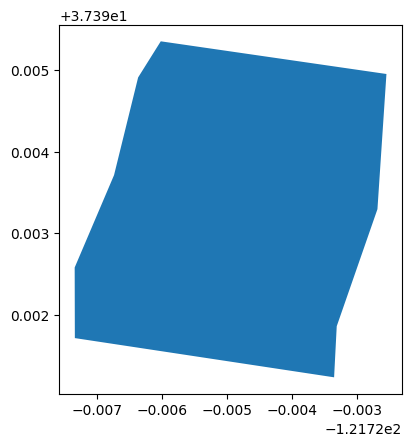

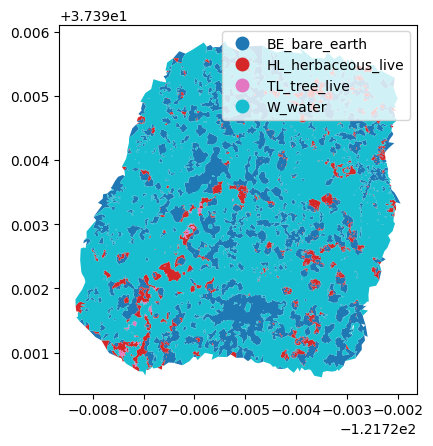

Simplifying 
Simplifying took 0.24152874946594238


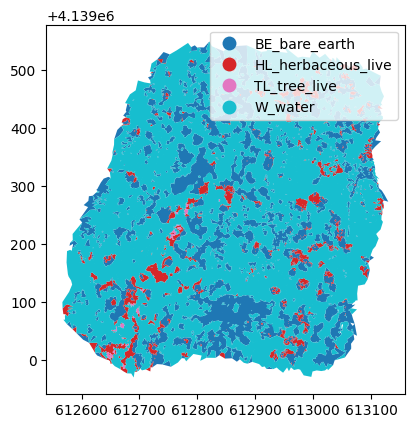

Buffering in
Buffering in took 5.345110654830933


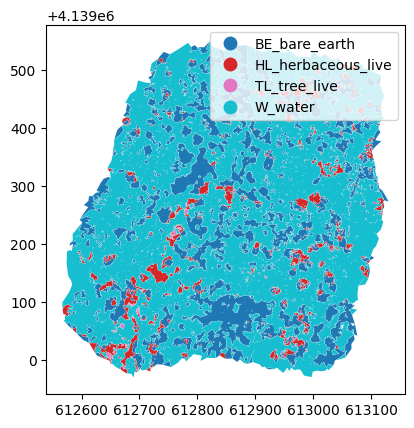

Buffering out


In [ ]:
if POST_PROCESS:
    # List all the files that are present
    map_files = sorted(GEOSPATIAL_MAPS_FOLDER.glob("*"))[START_IND:STOP_IND]

    for map_file in map_files:
        dataset_id = map_file.stem

        output_file = Path(POST_PROCESSED_MAPS_FOLDER, map_file.relative_to(GEOSPATIAL_MAPS_FOLDER))
        if SKIP_EXISTING and output_file.is_file():
            print(f"{output_file} exists, skipping")
            continue

        # get the associated metadata entry
        metadata = metadata_for_missions.query("mission_id == @dataset_id")
        if VIS:
            metadata.plot()
            plt.show()

        preds = gpd.read_file(map_file)
        if VIS:
            preds.plot("class_names", legend=True)
            plt.show()

        # Make sure this is in a projected CRS so geometric operations work as expected
        preds = ensure_projected_CRS(preds)
        # Simplify the geometry to make future operations faster
        print("Simplifying ")
        start = time.time()
        preds.geometry = preds.simplify(SIMPLIFY_TOL)
        print(f"Simplifying took {time.time() - start}")
        if VIS:
            preds.plot("class_names", legend=True)
            plt.show()

        print("Buffering in")
        start = time.time()
        preds.geometry = preds.buffer(-BUFFER_AMOUNT)
        print(f"Buffering in took {time.time() - start}")
        if VIS:
            preds.plot("class_names", legend=True)
            plt.show()

        print("Buffering out")
        start = time.time()
        preds.geometry = preds.buffer(2 * BUFFER_AMOUNT)
        print(f"Buffering out took {time.time() - start}")
        if VIS:
            preds.plot("class_names", legend=True)
            plt.show()

        print("Buffering in")
        start = time.time()
        preds.geometry = preds.buffer(-BUFFER_AMOUNT)
        print(f"Buffering in took {time.time() - start}")
        if VIS:
            preds.plot("class_names", legend=True)
            plt.show()

        print("Simplifying again")
        start = time.time()
        preds.geometry = preds.simplify(SIMPLIFY_TOL)
        print(f"Simplifying took {time.time() - start}")
        if VIS:
            preds.plot("class_names", legend=True)
            plt.show()

        # Favor the class with the smallest area
        print("Ensuring non-overlapping polygons")
        start = time.time()
        preds = ensure_non_overlapping_polygons(preds)
        print(f"Non-overlapping {time.time() - start}")
        if VIS:
            preds.plot("class_names", legend=True)
            plt.show()

        # Consider doing the thing to make classes non-overlapping by taking the rarest class

        preds.to_crs(metadata.crs, inplace=True)

        print("Clipping")
        start = time.time()
        preds = gpd.clip(gdf=preds, mask=metadata, keep_geom_type=True)
        print(f"Clipping took {time.time() - start}")
        if VIS:
            preds.plot("class_names", legend=True)
            plt.show()

        # Create containing directory and save file
        output_file.parent.mkdir(exist_ok=True)
        preds.to_file(output_file)

In [ ]:
if SHIFT:
    # List all the files that are present
    map_files = sorted(POST_PROCESSED_MAPS_FOLDER.glob("*"))[START_IND:STOP_IND]

    with open(SHIFT_PER_DATASET, "r") as infile:
        shifts_per_dataset = json.load(infile)

    for map_file in map_files:
        # Read the file
        pred = gpd.read_file(map_file)
        # Record the original CRS
        original_crs = pred.crs

        # Convert to a projected CRS
        pred = ensure_projected_CRS(pred)

        # Get the shift
        name = map_file.stem
        if not name in shifts_per_dataset:
            print(f"Using (0, 0) for {name} since there is no shift")
            shift = (0, 0)
        else:
            shift = shifts_per_dataset[name]

        # Apply the shift
        pred.geometry = pred.translate(xoff=shift[0], yoff=shift[1])

        # Convert back to the original CRS
        pred.to_crs(original_crs, inplace=True)

        output_file = Path(SHIFTED_MAPS_FOLDER, map_file.relative_to(POST_PROCESSED_MAPS_FOLDER))
        # Create the output folder and save
        output_file.parent.mkdir(parents=True, exist_ok=True)
        pred.to_file(output_file)
        print(f"Shifted {name}")


Shifted 000479
Shifted 000544
Shifted 000546
Shifted 000547
Shifted 000548
Shifted 000549
Shifted 000551
Shifted 000555
Shifted 000557
Using (0, 0) for 000558 since there is no shift
Shifted 000558
Shifted 000559
Shifted 000563
Shifted 000564
Shifted 000565
Shifted 000566
Shifted 000567
Shifted 000568
Shifted 000570
Shifted 000574
Shifted 000576
Using (0, 0) for 000577 since there is no shift
Shifted 000577
Shifted 000578
Shifted 000579
Shifted 000580
Using (0, 0) for 000582 since there is no shift
Shifted 000582
Using (0, 0) for 000583 since there is no shift
Shifted 000583
Using (0, 0) for 000584 since there is no shift
Shifted 000584
Using (0, 0) for 000585 since there is no shift
Shifted 000585
Using (0, 0) for 000586 since there is no shift
Shifted 000586
Using (0, 0) for 000587 since there is no shift
Shifted 000587
Using (0, 0) for 000588 since there is no shift
Shifted 000588
Shifted 000610
Shifted 000611
Shifted 000612
Shifted 000613
Shifted 000614
Shifted 000619
Shifted 00062